# *Covid19* - Variation in CO2 Emission from Europe’s electricity system

In [1]:
import sys
import os
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *

## QGIS inicialization

In [2]:
QgsApplication.setPrefixPath(r'C:\Program Files\QGIS 3.12\apps\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\Program Files\QGIS 3.12\apps\qgis\python\plugins')

In [3]:
study = QgsProject.instance()

## Import Map Layer

In [4]:
eu_path = "files/countries/ne_10m_admin_0_countries.shp"
eu_layer = QgsVectorLayer(eu_path, 'EU Map', 'ogr')

if not eu_layer.isValid():
    print("Failed to load the layer!")
else:
    crs = QgsCoordinateReferenceSystem('EPSG:5071')
    eu_layer.setCrs(crs)
    study.addMapLayer(eu_layer)

## Read CSV with Pandas

In [5]:
import pandas as pd

# Energatic Falling Demand
V = pd.read_csv("files/csv/paises.csv")
V.head(V.shape[0])

,Country,Value
0,Italy,-23
1,Spain,-18
2,France,-17
3,Romania,-16
4,Slovenia,-16
5,Belgium,-16
6,United Kingdom,-15
7,Portugal,-12
8,Greece,-12
9,Slovakia,-12


In [6]:
# Energetic Sources
E = pd.read_csv("files/csv/emissoes.csv")
E.head(E.shape[0])

,Source,Value
0,Emission,-39
1,Lignite,-43
2,Hard Coal,-42
3,Other fossil,-39
4,Gas,-30
5,Nuclear,-16
6,All Fuels,-14
7,Wind,-1
8,Other renewables,2
9,Hydro,9


## Variation Graphic with Matplotlib

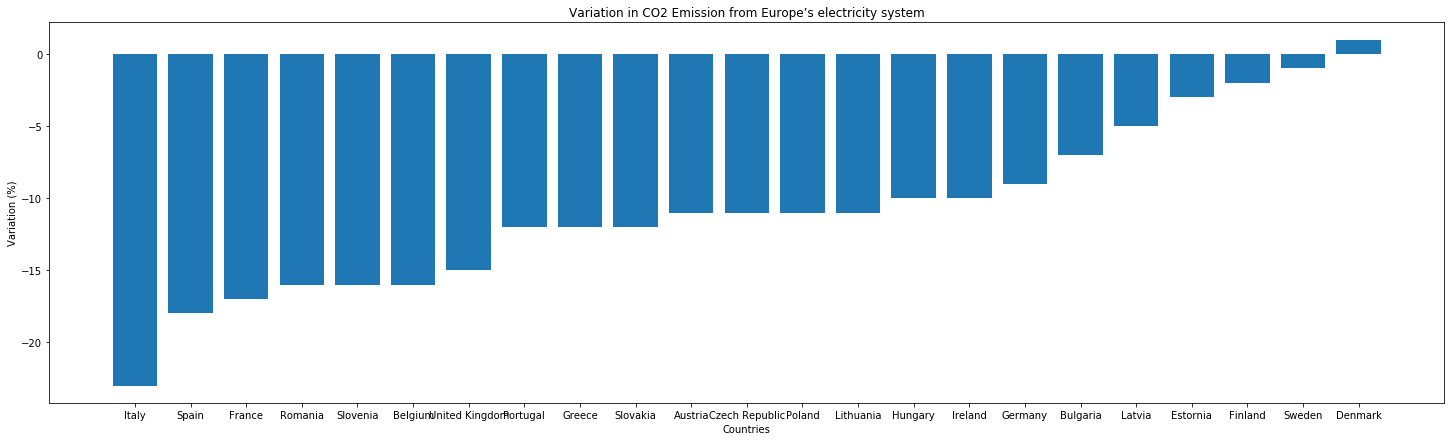

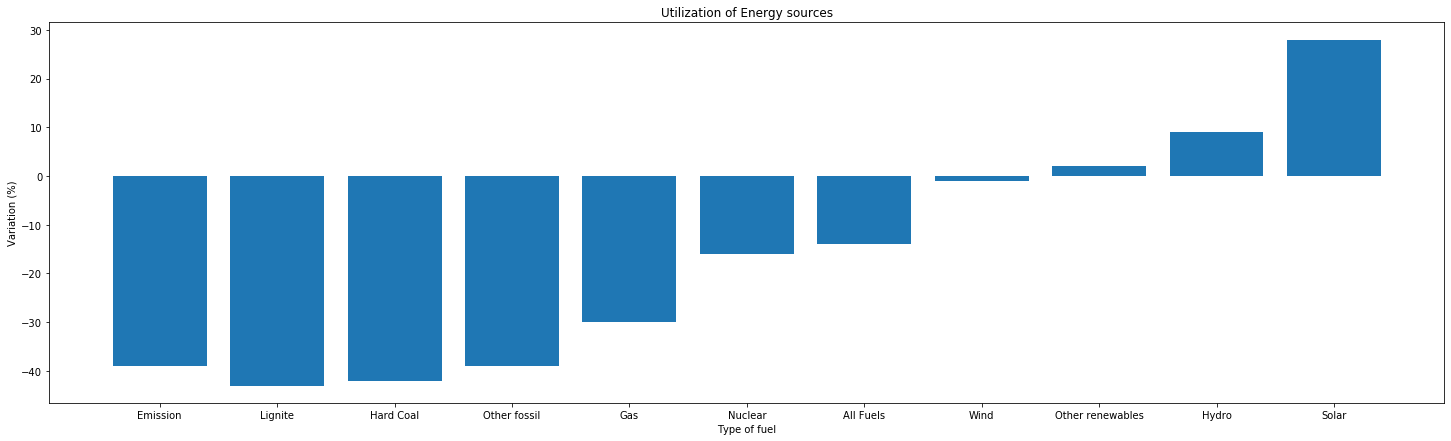

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 7))
plt.bar(V.Country, V.Value)
plt.xlabel('Countries')
plt.ylabel('Variation (%)')
plt.title('Variation in CO2 Emission from Europe’s electricity system')
plt.show()

plt.figure(figsize=(25, 7))
plt.bar(E.Source,E.Value)
plt.xlabel('Type of fuel')
plt.ylabel('Variation (%)')
plt.title('Utilization of Energy sources')
plt.show()

## Load CSV Layer

In [8]:
val_path = "file:files/csv/paises.csv"
layer_name = 'paises'
val_layer = QgsVectorLayer(val_path, layer_name, 'delimitedtext')

if not val_layer.isValid():
    print('Layer failed to load!')
else:
    study.addMapLayer(val_layer)

In [9]:
def joinCSVSHPLayers(csv_layer):
    joinObject = QgsVectorLayerJoinInfo()
    joinObject.setJoinFieldName('Country')
    joinObject.setTargetFieldName('NAME')
    joinObject.setJoinLayerId(csv_layer.id())
    joinObject.setUsingMemoryCache(True)
    joinObject.setJoinLayer(csv_layer)
    info = eu_layer.addJoin(joinObject)
    return info

csv_layer = study.mapLayersByName('paises')[0]
info = joinCSVSHPLayers(csv_layer)

In [10]:
remove = []

for feature in eu_layer.getFeatures():
    #print(feature['paises_Value'])
    
    if feature['paises_Value'] is None:
        remove.append(feature.id())
        
caps = eu_layer.dataProvider().capabilities()

if caps & QgsVectorDataProvider.DeleteFeatures:
    res = eu_layer.dataProvider().deleteFeatures(remove)

In [11]:
target_field = 'paises_Value'
mList = []

symbol = QgsSymbol.defaultSymbol(eu_layer.geometryType())     
symbol.setColor(QColor(255,105,180))                              
less = QgsRendererRange(-14, 5, symbol, 'Less than Total')
mList.append(less)

symbol = QgsSymbol.defaultSymbol(eu_layer.geometryType())
symbol.setColor(QColor(0,128,0))
more = QgsRendererRange(-25, -14, symbol, 'More than Total')
mList.append(more)

mR = QgsGraduatedSymbolRenderer(target_field, mList)
mR.setMode(QgsGraduatedSymbolRenderer.Custom)               

eu_layer.setRenderer(mR)

C:\PROGRA~1\QGIS3~1.12\apps\Python37\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: QgsGraduatedSymbolRenderer.setMode() is deprecated
  from ipykernel import kernelapp as app


In [12]:
x = eu_layer.extent()

width  = 2000
height = int(width*x.height()/x.width())
print("Map size: {} x {}".format(width, height))

opt = QgsMapSettings()
opt.setLayers([eu_layer])
opt.setBackgroundColor(QColor(255, 255, 255))
opt.setOutputSize(QSize(width, height))
opt.setExtent(x)
opt.setDestinationCrs(eu_layer.crs())
opt.destinationCrs()

render = QgsMapRendererParallelJob(opt)
render.start()
render.waitForFinished()

image = render.renderedImage()

Map size: 2000 x 1554


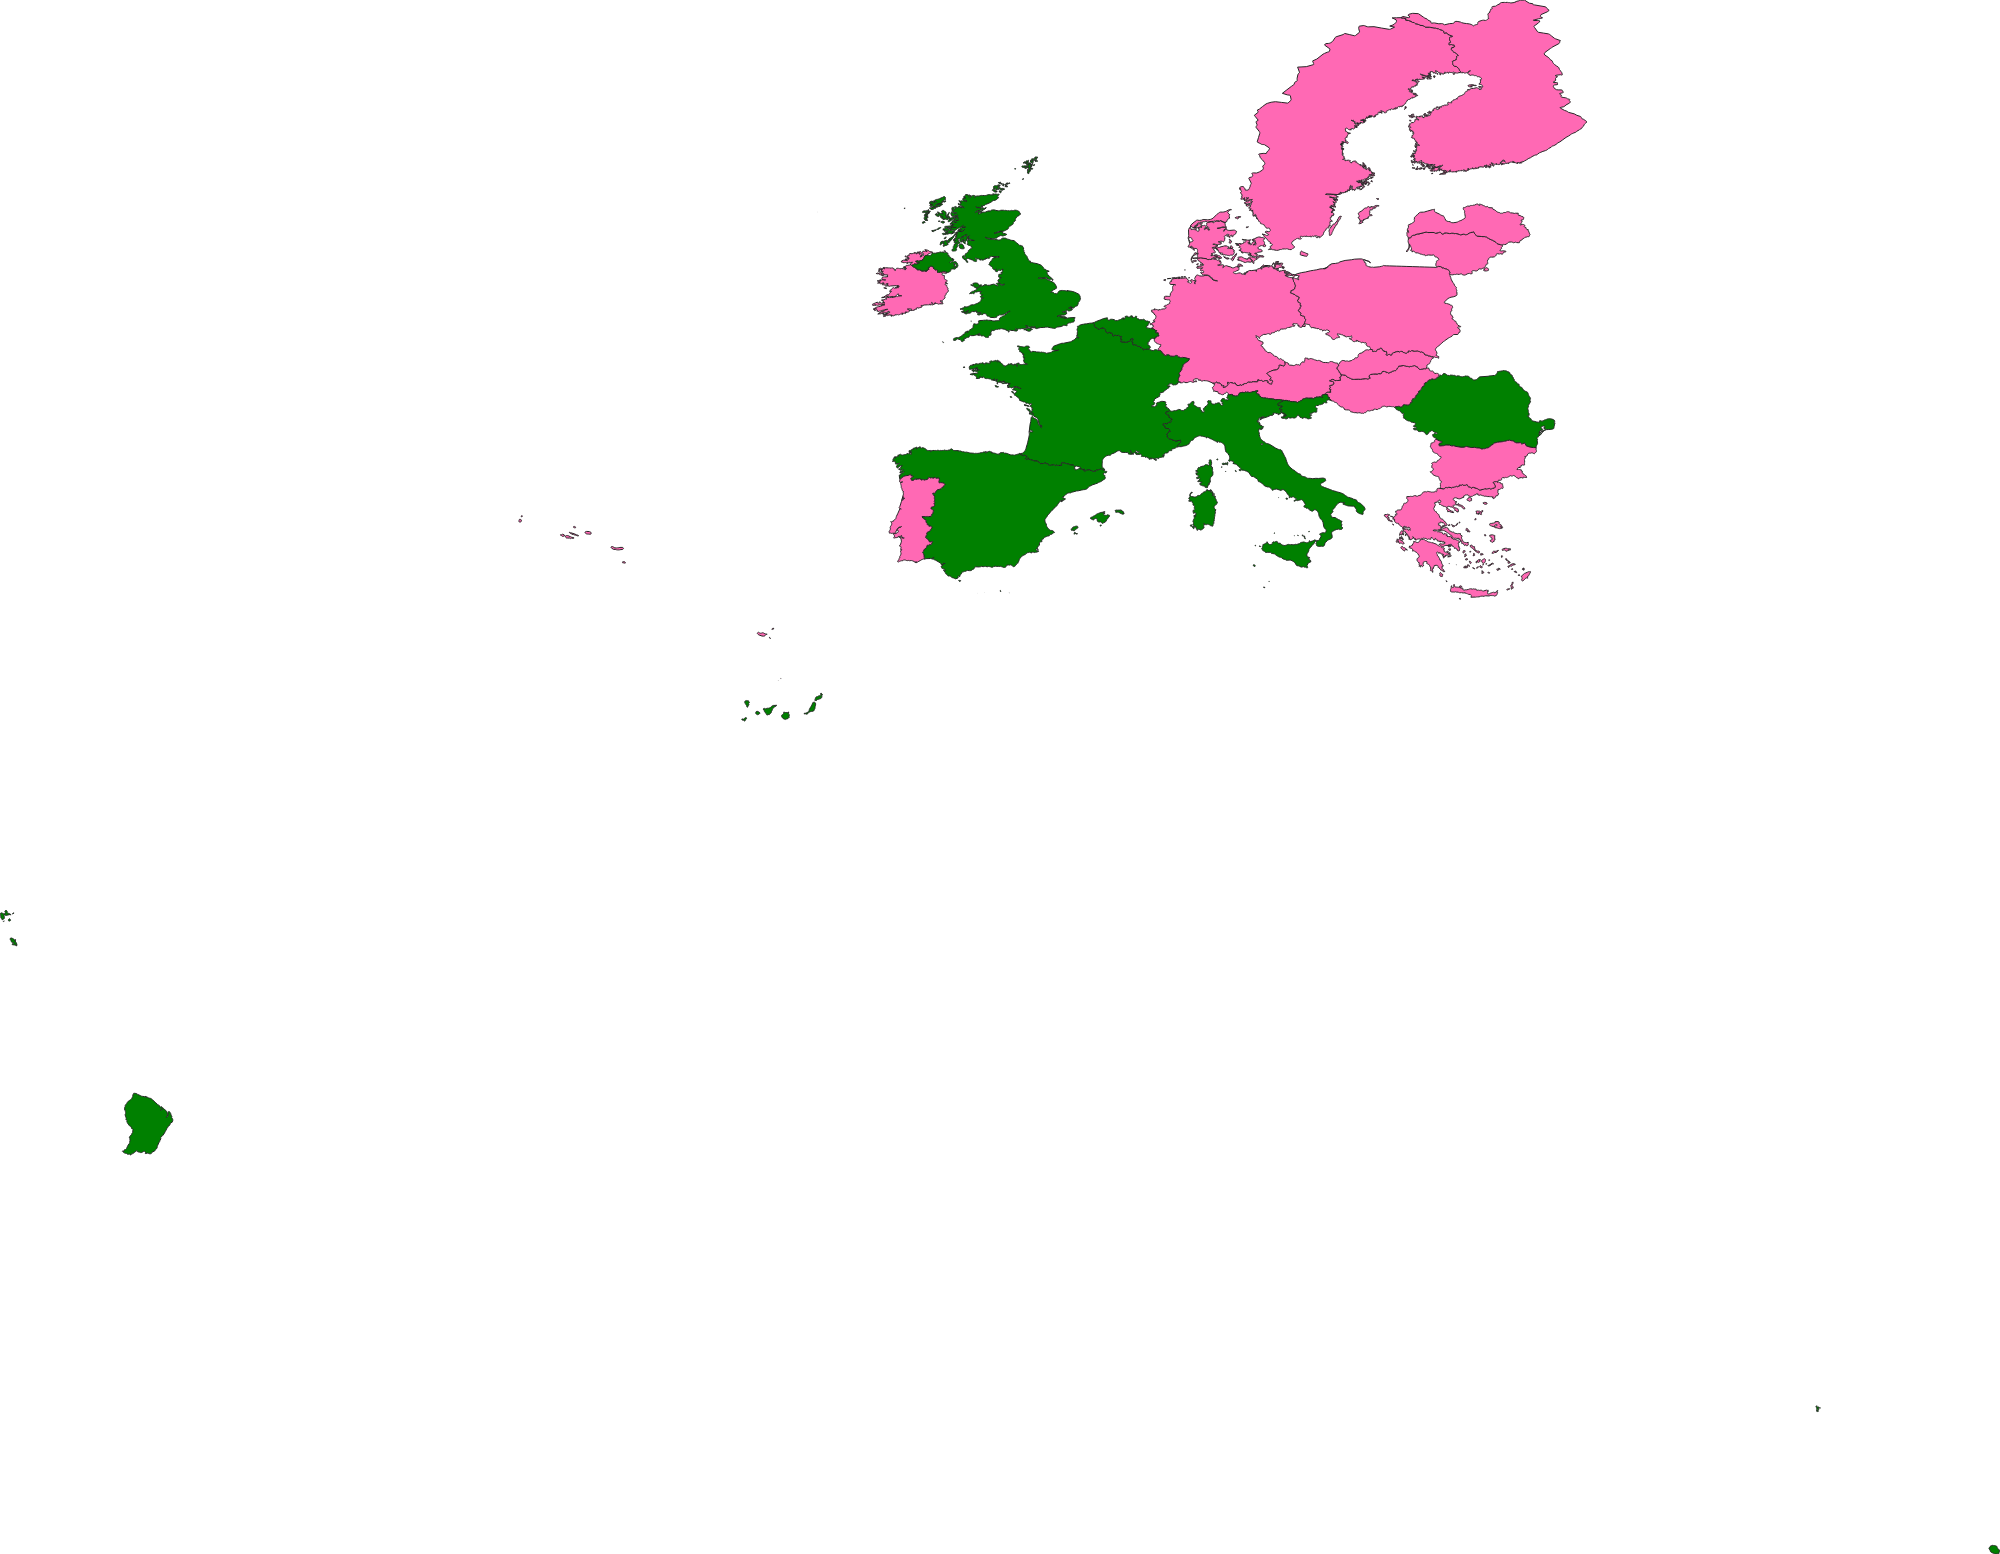

In [13]:
from IPython.display import Image

imgbuf = QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

### References

https://www.carbonbrief.org/analysis-coronavirus-has-cut-co2-from-europes-electricity-system-by-39-per-cent